In [1]:
!pip install --upgrade keras

In [2]:
!pip install gymnasium
!pip install JSAnimation

In [3]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class QNetwork(Model):
    def __init__(self, m, n, alpha):
        super(QNetwork, self).__init__()
        # Define the architecture
        self.input_layer = Input(shape=(m,))
        self.dense_layer = Dense(n, kernel_initializer='random_normal',
                                 bias_initializer='random_normal')

        # Compile model
        self.compile(optimizer=SGD(learning_rate=alpha), loss='mse')

    def call(self, inputs):
        x = self.dense_layer(inputs)
        return x

    def get_action(self, s):
        Q_values = self(tf.convert_to_tensor([s], dtype=tf.float32))
        action = tf.argmax(Q_values, axis=1).numpy()[0]  # Extract the first element to get a scalar
        return action, Q_values.numpy()

    def learnQ(self, s, Q_hat):
        self.train_on_batch(x=tf.convert_to_tensor([s], dtype=tf.float32),
                            y=tf.convert_to_tensor([Q_hat], dtype=tf.float32))

    def Qnew(self, s):
        return self(tf.convert_to_tensor([s], dtype=tf.float32)).numpy()

In [4]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
obs, info = env.reset()

In [5]:
m = env.observation_space.n # size of the state space
n = env.action_space.n # size of action space

gamma = 0.97
max_episode = 50
max_steps = 10
alpha = 0.7
epsilon = 0.3

In [6]:

QNN = QNetwork(m, n, alpha)  # Initialize the Q-network
rewards = []  # To store total rewards per episode

for i in range(max_episode):
    s = env.reset()  # Start with new environment
    S = np.identity(m)[s[0]]  # One-hot encode the state
    done = False
    rtot = 0  # Reset total reward for the episode

    for jj in range(max_steps):
        a, _ = QNN.get_action(S)  # Get action from Q-network (not using Q-values yet)
        p = np.random.rand()
        if p > epsilon:
            a = env.action_space.sample()  # Explore: random action
        #print(i, jj, a, p)
        s_new, r, truncated, terminated, _ = env.step(a)  # Perform action
        rtot += r  # Accumulate reward

        # Prepare next state
        S_new = np.identity(m)[s_new]  # One-hot encode the new state
        Q_new = QNN.Qnew(S_new)  # Get new Q-values from network
        maxQ = np.max(Q_new)  # Find max Q-value for updating

        # Update target Q-value for training
        Q_hat = QNN.Qnew(S)  # Get current Q-values
        Q_hat[0, a] = r + gamma * maxQ  # Apply Bellman equation
        QNN.learnQ(S, Q_hat)  # Train network

        S = S_new  # Update state

        if done:
            break  # Exit loop if the episode is finished

    rewards.append(rtot)  # Store total reward for this episode

# Print average reward
print("Total reward per episode is: " + str(sum(rewards) / max_episode))


Total reward per episode is: -32.5


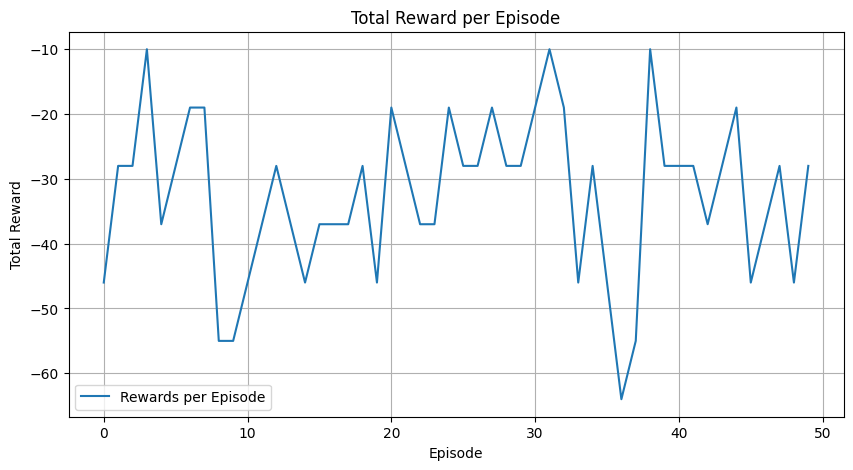

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(rewards, label='Rewards per Episode')  # Plot rewards
plt.xlabel('Episode')  # Label for the x-axis
plt.ylabel('Total Reward')  # Label for the y-axis
plt.title('Total Reward per Episode')  # Title of the plot
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot


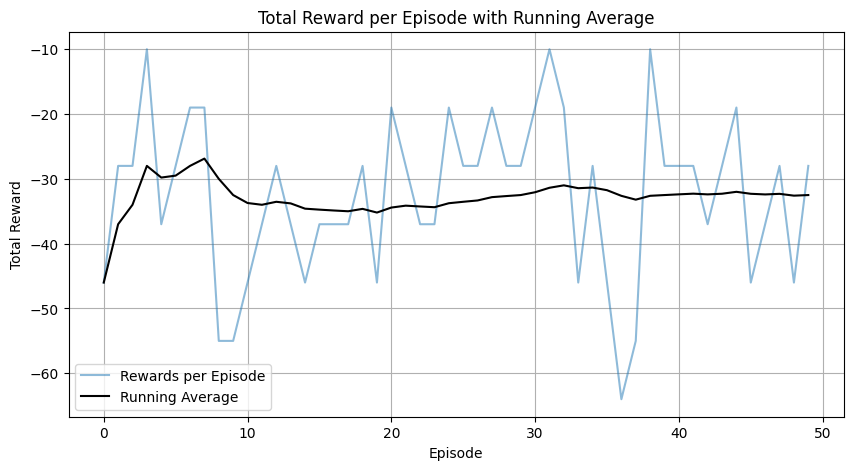

In [8]:
window_size = 50  # Example window size for averaging
smoothed_rewards = [np.mean(rewards[i-window_size:i+1]) if i >= window_size else np.mean(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='Rewards per Episode', alpha=0.5)  # Original rewards, more transparent
plt.plot(smoothed_rewards, label='Running Average', color='black')  # Smoothed rewards
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode with Running Average')
plt.legend()
plt.grid(True)
plt.show()
